** Different Network topologies for Deeper Network Configration **

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/35
781/781 [==============================] - 46s 59ms/step - loss: 1.6412 - acc: 0.3967 - val_loss: 1.3446 - val_acc: 0.5177
Epoch 2/35
781/781 [==============================] - 44s 56ms/step - loss: 1.2859 - acc: 0.5390 - val_loss: 1.1012 - val_acc: 0.6171
Epoch 3/35
781/781 [==============================] - 42s 54ms/step - loss: 1.1256 - acc: 0.5998 - val_loss: 0.9285 - val_acc: 0.6739
Epoch 4/35
781/781 [==============================] - 44s 56ms/step - loss: 1.0246 - acc: 0.6398 - val_loss: 0.8426 - val_acc: 0.7009
Epoch 5/35
781/781 [==============================] - 43s 55ms/step - loss: 0.9410 - acc: 0.6695 - val_loss: 0.7821 - val_acc: 0.7280
Epoch 6/35
781/781 [==============================] - 43s 55ms/step - loss: 0.8833 - acc: 0.6910 - val_loss: 0.8046 - val_acc: 0.7191
Epoch 7/35
781/781 [==============================] - 42s 54ms/step - loss: 0.8308 - acc

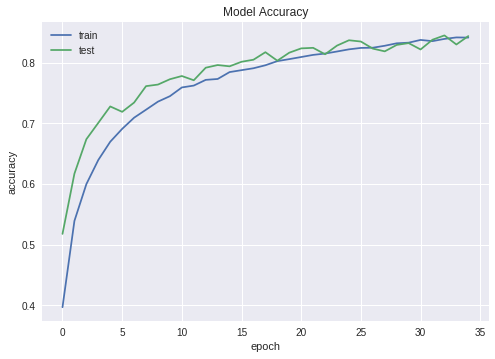

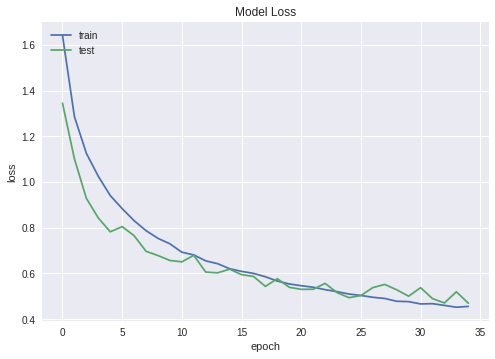

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 64
num_classes = 10
epochs = 35
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/35
781/781 [==============================] - 47s 61ms/step - loss: 1.7281 - acc: 0.3632 - val_loss: 1.3787 - val_acc: 0.5006
Epoch 2/35
781/781 [==============================] - 46s 59ms/step - loss: 1.4360 - acc: 0.4794 - val_loss: 1.2840 - val_acc: 0.5438
Epoch 3/35
781/781 [==============================] - 46s 58ms/step - loss: 1.3038 - acc: 0.5327 - val_loss: 1.1799 - val_acc: 0.5799
Epoch 4/35
781/781 [==============================] - 46s 59ms/step - loss: 1.2182 - acc: 0.5668 - val_loss: 1.0461 - val_acc: 0.6215
Epoch 5/35
781/781 [==============================] - 47s 60ms/step - loss: 1.1575 - acc: 0.5879 - val_loss: 1.0695 - val_acc: 0.6252
Epoch 6/35
781/781 [==============================] - 45s 58ms/step - loss: 1.1108 - acc: 0.6043 - val_loss: 0.9757 - val_acc: 0.6553
Epoch 7/35
781/781 [==============================] - 47s 60ms/step - loss: 1.0664 - acc

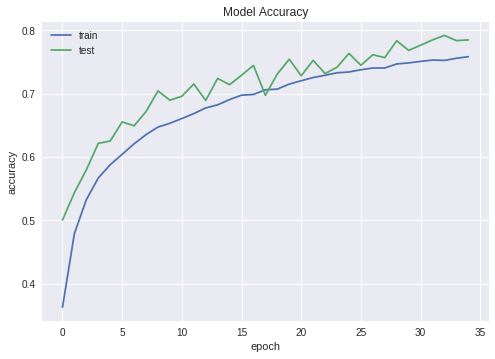

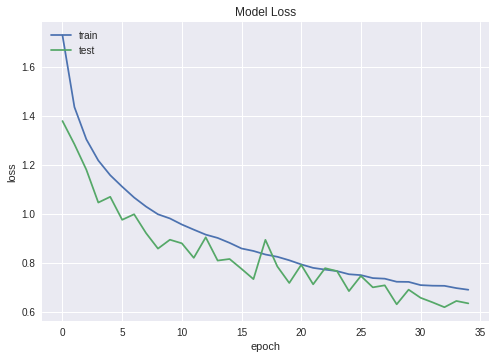

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 64
num_classes = 10
epochs = 35
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/60
781/781 [==============================] - 70s 90ms/step - loss: 1.7170 - acc: 0.3674 - val_loss: 1.3559 - val_acc: 0.5029
Epoch 2/60
781/781 [==============================] - 65s 84ms/step - loss: 1.4273 - acc: 0.4800 - val_loss: 1.2141 - val_acc: 0.5655
Epoch 3/60
781/781 [==============================] - 71s 91ms/step - loss: 1.2962 - acc: 0.5351 - val_loss: 1.0555 - val_acc: 0.6168
Epoch 4/60
781/781 [==============================] - 65s 83ms/step - loss: 1.2147 - acc: 0.5646 - val_loss: 1.0831 - val_acc: 0.6228
Epoch 5/60
781/781 [==============================] - 68s 87ms/step - loss: 1.1425 - acc: 0.5938 - val_loss: 0.9554 - val_acc: 0.6591
Epoch 6/60
781/781 [==============================] - 66s 84ms/step - loss: 1.0929 - acc: 0.6133 - val_loss: 0.9274 - val_acc: 0.6809
Epoch 7/60
781/781 [==============================] - 68s 87ms/step - loss: 1.0492 - acc

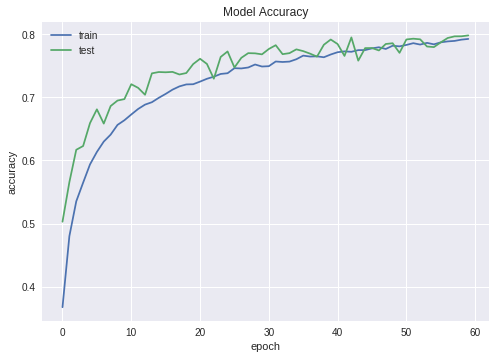

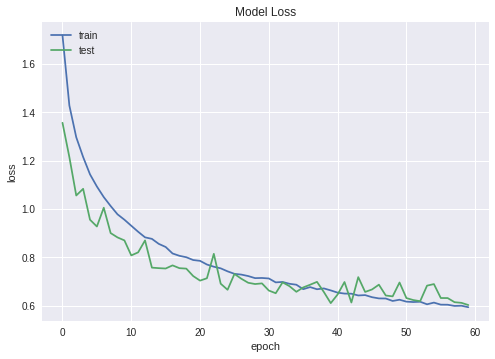

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 64
num_classes = 10
epochs = 60
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/40
390/390 [==============================] - 44s 114ms/step - loss: 1.9598 - acc: 0.2660 - val_loss: 1.6502 - val_acc: 0.3793
Epoch 2/40
390/390 [==============================] - 42s 109ms/step - loss: 1.6657 - acc: 0.3823 - val_loss: 1.5266 - val_acc: 0.4431
Epoch 3/40
390/390 [==============================] - 43s 111ms/step - loss: 1.5493 - acc: 0.4278 - val_loss: 1.3393 - val_acc: 0.5124
Epoch 4/40
390/390 [==============================] - 43s 110ms/step - loss: 1.4580 - acc: 0.4665 - val_loss: 1.2739 - val_acc: 0.5339
Epoch 5/40
390/390 [==============================] - 42s 109ms/step - loss: 1.3891 - acc: 0.4944 - val_loss: 1.2590 - val_acc: 0.5400
Epoch 6/40
390/390 [==============================] - 43s 110ms/step - loss: 1.3341 - acc: 0.5155 - val_loss: 1.1888 - val_acc: 0.5743
Epoch 7/40
390/390 [==============================] - 43s 110ms/step - loss: 1.281

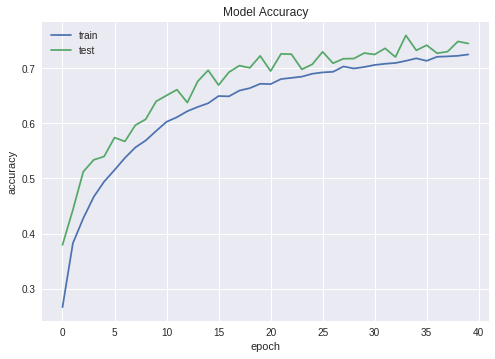

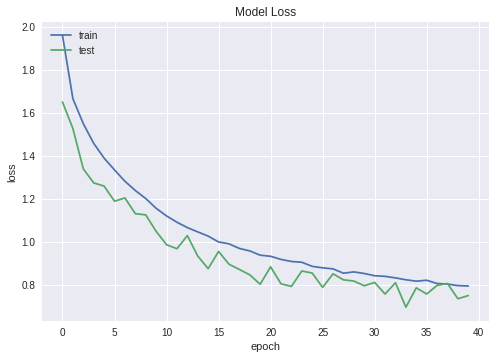

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 40
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(80, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/50
357/357 [==============================] - 45s 126ms/step - loss: 1.7309 - acc: 0.3671 - val_loss: 1.4231 - val_acc: 0.4866
Epoch 2/50
357/357 [==============================] - 42s 119ms/step - loss: 1.4449 - acc: 0.4809 - val_loss: 1.3032 - val_acc: 0.5324
Epoch 3/50
357/357 [==============================] - 41s 115ms/step - loss: 1.3032 - acc: 0.5332 - val_loss: 1.1221 - val_acc: 0.5996
Epoch 4/50
357/357 [==============================] - 41s 114ms/step - loss: 1.2188 - acc: 0.5650 - val_loss: 1.0815 - val_acc: 0.6246
Epoch 5/50
357/357 [==============================] - 41s 116ms/step - loss: 1.1607 - acc: 0.5887 - val_loss: 0.9908 - val_acc: 0.6504
Epoch 6/50
357/357 [==============================] - 41s 114ms/step - loss: 1.1061 - acc: 0.6078 - val_loss: 0.9827 - val_acc: 0.6559
Epoch 7/50
357/357 [==============================] - 42s 117ms/step - loss: 1.069

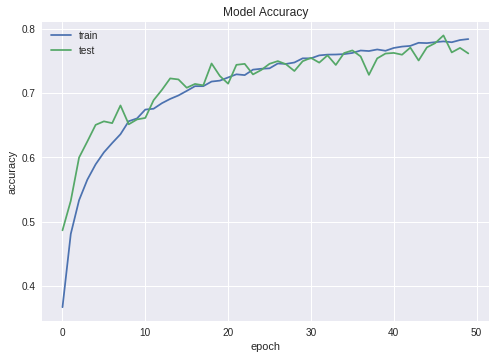

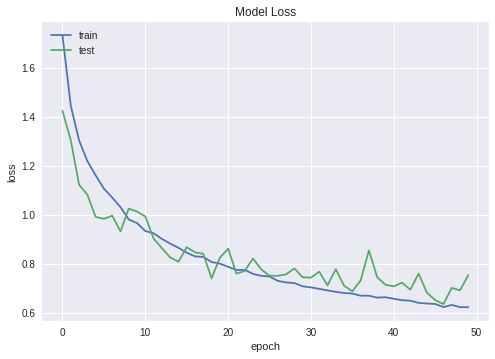

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 140
num_classes = 10
epochs = 50
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

#model.add(Conv2D(32, (3, 3), padding='same'))
#model.add(Activation('elu'))
#model.add(Conv2D(80, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
#model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/55
781/781 [==============================] - 48s 62ms/step - loss: 1.9837 - acc: 0.2772 - val_loss: 1.7480 - val_acc: 0.3776
Epoch 2/55
781/781 [==============================] - 47s 60ms/step - loss: 1.7511 - acc: 0.3721 - val_loss: 1.5893 - val_acc: 0.4287
Epoch 3/55
781/781 [==============================] - 47s 60ms/step - loss: 1.6594 - acc: 0.4048 - val_loss: 1.5522 - val_acc: 0.4484
Epoch 4/55
781/781 [==============================] - 47s 61ms/step - loss: 1.6056 - acc: 0.4265 - val_loss: 1.4216 - val_acc: 0.4961
Epoch 5/55
781/781 [==============================] - 54s 70ms/step - loss: 1.5586 - acc: 0.4440 - val_loss: 1.5274 - val_acc: 0.4602
Epoch 6/55
781/781 [==============================] - 66s 85ms/step - loss: 1.5112 - acc: 0.4601 - val_loss: 1.3738 - val_acc: 0.5130
Epoch 7/55
781/781 [==============================] - 67s 86ms/step - loss: 1.4674 - acc

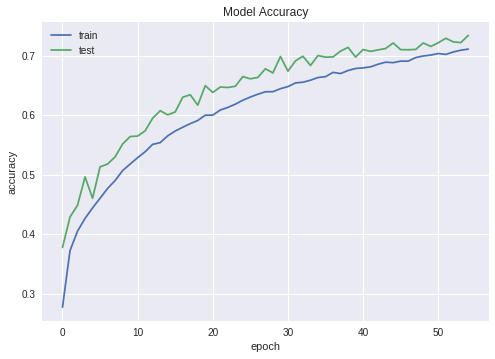

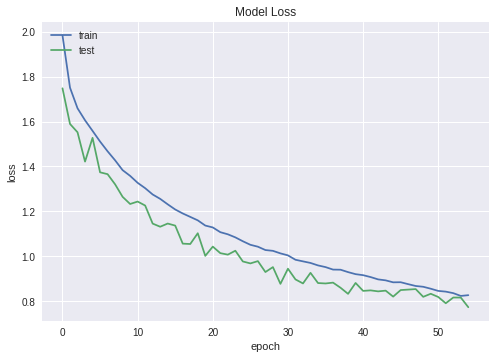

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import SGD
import os
import matplotlib.pyplot as plt

batch_size = 64
num_classes = 10
epochs = 55
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

#model.add(Conv2D(32, (3, 3), padding='same'))
#model.add(Activation('elu'))
#model.add(Conv2D(80, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.SGD()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/75
781/781 [==============================] - 47s 61ms/step - loss: 2.0019 - acc: 0.2728 - val_loss: 1.7171 - val_acc: 0.4017
Epoch 2/75
781/781 [==============================] - 46s 59ms/step - loss: 1.7305 - acc: 0.3796 - val_loss: 1.6562 - val_acc: 0.4087
Epoch 3/75
781/781 [==============================] - 46s 59ms/step - loss: 1.6241 - acc: 0.4171 - val_loss: 1.5148 - val_acc: 0.4574
Epoch 4/75
781/781 [==============================] - 46s 58ms/step - loss: 1.5415 - acc: 0.4467 - val_loss: 1.4224 - val_acc: 0.5004
Epoch 5/75
781/781 [==============================] - 46s 59ms/step - loss: 1.4757 - acc: 0.4733 - val_loss: 1.3344 - val_acc: 0.5220
Epoch 6/75
781/781 [==============================] - 45s 58ms/step - loss: 1.4305 - acc: 0.4894 - val_loss: 1.3486 - val_acc: 0.5224
Epoch 7/75
781/781 [==============================] - 46s 59ms/step - loss: 1.3857 - acc

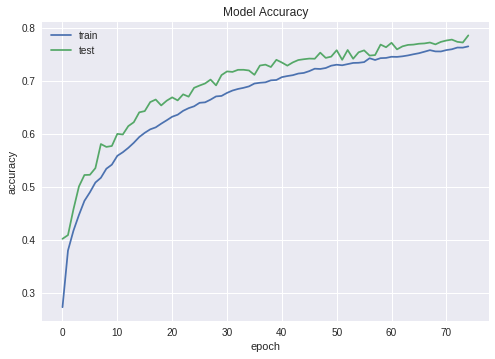

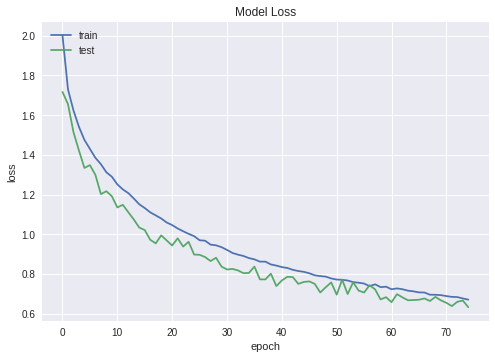

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import SGD
import os
import matplotlib.pyplot as plt

batch_size = 64
num_classes = 10
epochs = 75
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

#model.add(Conv2D(32, (3, 3), padding='same'))
#model.add(Activation('elu'))
#model.add(Conv2D(80, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.SGD()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/60
390/390 [==============================] - 122s 313ms/step - loss: 1.8439 - acc: 0.3042 - val_loss: 1.4843 - val_acc: 0.4455
Epoch 2/60
390/390 [==============================] - 98s 252ms/step - loss: 1.3804 - acc: 0.4951 - val_loss: 1.1953 - val_acc: 0.5604
Epoch 3/60
390/390 [==============================] - 97s 248ms/step - loss: 1.1557 - acc: 0.5840 - val_loss: 1.0013 - val_acc: 0.6408
Epoch 4/60
390/390 [==============================] - 100s 255ms/step - loss: 1.0125 - acc: 0.6400 - val_loss: 0.9449 - val_acc: 0.6672
Epoch 5/60
390/390 [==============================] - 98s 252ms/step - loss: 0.8864 - acc: 0.6888 - val_loss: 0.7530 - val_acc: 0.7364
Epoch 6/60
390/390 [==============================] - 97s 249ms/step - loss: 0.8090 - acc: 0.7154 - val_loss: 0.7248 - val_acc: 0.7513
Epoch 7/60
390/390 [==============================] - 97s 247ms/step - loss: 0.7

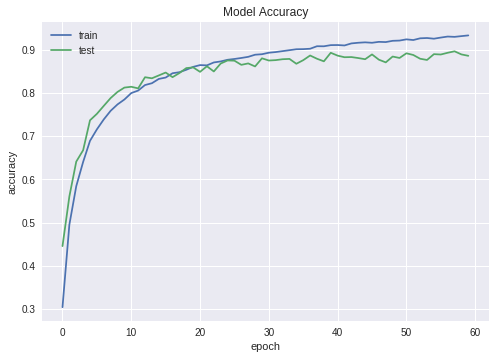

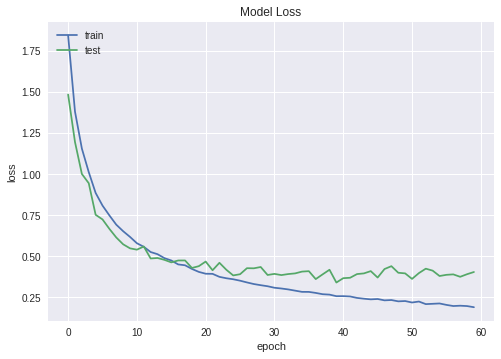

In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 60
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/65
390/390 [==============================] - 44s 112ms/step - loss: 1.7752 - acc: 0.3345 - val_loss: 1.3974 - val_acc: 0.4860
Epoch 2/65
390/390 [==============================] - 42s 108ms/step - loss: 1.3429 - acc: 0.5089 - val_loss: 1.1296 - val_acc: 0.5800
Epoch 3/65
390/390 [==============================] - 42s 108ms/step - loss: 1.1348 - acc: 0.5908 - val_loss: 1.0504 - val_acc: 0.6318
Epoch 4/65
390/390 [==============================] - 42s 108ms/step - loss: 0.9752 - acc: 0.6518 - val_loss: 0.8173 - val_acc: 0.7084
Epoch 5/65
390/390 [==============================] - 42s 108ms/step - loss: 0.8684 - acc: 0.6946 - val_loss: 0.7932 - val_acc: 0.7257
Epoch 6/65
390/390 [==============================] - 42s 108ms/step - loss: 0.7982 - acc: 0.7205 - val_loss: 0.6979 - val_acc: 0.7609
Epoch 7/65
390/390 [==============================] - 42s 108ms/step - loss: 0.727

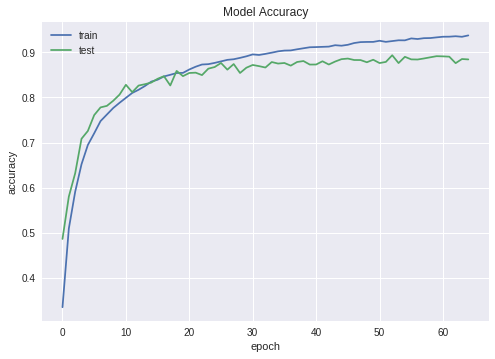

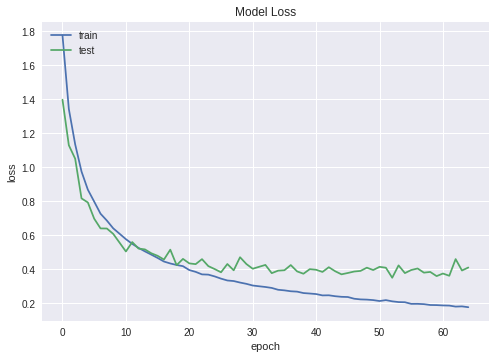

In [2]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 65
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.24))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.24))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils.sequence  import steps_per_epoch 
from keras.optimizers import adamax
import os
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 65
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.24))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.24))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.adamax()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history=model.fit_generator(datagen.flow(x_train, y_train,

                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# list all data in history
print(train_history.history.keys())
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/65
390/390 [==============================] - 44s 112ms/step - loss: 1.8693 - acc: 0.2891 - val_loss: 1.4881 - val_acc: 0.4426
Epoch 2/65
390/390 [==============================] - 42s 108ms/step - loss: 1.4175 - acc: 0.4744 - val_loss: 1.1805 - val_acc: 0.5735
Epoch 3/65
390/390 [==============================] - 42s 107ms/step - loss: 1.2052 - acc: 0.5667 - val_loss: 0.9853 - val_acc: 0.6501
Epoch 4/65
390/390 [==============================] - 42s 108ms/step - loss: 1.0545 - acc: 0.6262 - val_loss: 0.8823 - val_acc: 0.6861
Epoch 5/65
390/390 [==============================] - 42s 108ms/step - loss: 0.9277 - acc: 0.6720 - val_loss: 0.8858 - val_acc: 0.6991
Epoch 6/65
390/390 [==============================] - 42s 108ms/step - loss: 0.8415 - acc: 0.7059 - val_loss: 0.7122 - val_acc: 0.7527
Epoch 7/65
390/390 [==============================] - 42s 108ms/step - loss: 0.777